In [3]:
import numpy as np
from Bio import Entrez
import gzip
import pickle

In [4]:
# In order to import from the python file without hassle, we add the current
# directory to the python path
import sys
sys.path.append(".")

Let's let the nice folks at NCBI know who we are.

In [5]:
Entrez.email = "sara.bizjak@student.fmf.uni-lj.si"
#"sarabizjak97@gmail.com"
#"sara.bizjak@student.fmf.uni-lj.si"

# Phylogenetic analysis of coronaviruses

In the first part of the homework, you will conduct a phylogenetic analysis of a handful of coronaviruses. You will look at the similarity between the DNA sequences of these viruses to determine how closely related they are to one another. This might give us some insight into how these viruses might have evolved through time, or from which species SARS-CoV-2 jumped to us, humans.

We will build a phylogenetic tree in two steps. First, we will calculate the distances between each pair of viral genomes. We can't just compare them directly, we have to align them first. So we will run global alignment to get an optimal alignment between each pair of viral genomes. Then, we will calculate the distance between these alignments using Hamming distance. This just checks the number of symbols in the two sequences which do not match. Having calculated all pairwise distances, we can build a dendrogram, which will serve as our phylogenetic tree.

**A note on runtime:** To build a phylogenetic tree, you will need to calculate all pairwise distances between several coronavirus genomes. As you have learned in lectures, computing an alignment between two sequences of length $N$ and $M$ requires forming and calculating a table of $N \cdot M$ entries. This is fine for small sequences, but genomes, even short ones like viral genomes, are generally too long for this. For this reason, we will not calculate pairwise alignments between complete viral genomes in our analysis, but we will focus on the spike protein sequence only. The spike protein is one of the most important parts of any virus, as it is the one that grants the virus entry to host cells. Also, doing so will reduce the sequence lengths from ~30k to around 1.3k, which is much more manageable. Even so, do your best to write fast, efficient Python code, as you will spend a long time waiting for your programs to complete otherwise.

**Speeding things up**: On my laptop, each `global_alignment` call on 1.3k long protein sequences takes around 30 seconds. We have to calculate 210 comparisons, which takes roughly two hours. For those of you who want to speed things up and play around with several parameter settings, you can take advantage of *numba*. *numba* is a Python JIT library, which compiles your code and makes it run faster. We will make *numba* available in the grading environment for this homework. This is not a requirement or even a recommendation, because *numba* can be a pain to work with. However, you are welcome to take advantage of this if you so wish.

In [6]:
accession_codes = {
    # 7 known human coronaviruses
    "Human-SARS-CoV-2": "NC_045512",
    "Human-SARS": "NC_004718",
    "Human-MERS": "NC_019843",
    "Human-HCoV-OC43": "NC_006213",
    "Human-HCoV-229E": "NC_002645",
    "Human-HCoV-NL63": "NC_005831",
    "Human-HCoV-HKU1": "NC_006577",
    
    # Bat
    "Bat-CoV MOP1": "EU420138",
    "Bat-CoV HKU8": "NC_010438",
    "Bat-CoV HKU2": "NC_009988",
    "Bat-CoV HKU5": "NC_009020",
    "Bat-CoV RaTG13": "MN996532",
    "Bat-CoV-ENT": "NC_003045",
    
    # Other animals
    "Hedgehog-CoV 2012-174/GER/2012": "NC_039207",
    "Pangolin-CoV MP789": "MT121216",
    "Rabbit-CoV HKU14": "NC_017083",
    "Duck-CoV isolate DK/GD/27/2014": "NC_048214",
    "Feline infectious peritonitis virus": "NC_002306",  # cat
    "Giraffe-CoV US/OH3/2003": "EF424623",
    "Murine-CoV MHV/BHKR_lab/USA/icA59_L94P/2012": "KF268338",  # mouse
    "Equine-CoV Obihiro12-2": "LC061274",  # horse
}

Here is the list of viruses and their accession codes that we will be working with in this homework. As mentioned in _a note on runtime_, we won't be using the entire sequence to infer phylogenies, but we'll only look at the spike protein. To get spike protein regions from a `SeqRecord` object, we have to inspect the `features` field of each record. Look through the gene coding regions (CDS) of each sequence and find the region that codes for the "S" gene. Some records won't have this field, so look for "spike protein" in the `product` field.

In [7]:
# I HAVE TROUBLES WITH "LOAD" SO IM OPENING SENT FILES 

# INSTRUCTIONS

# 1. load sequences
# 2. extract spike protein regions
# 3. convert to amino-acid sequences


from Bio.SeqFeature import SeqFeature, FeatureLocation
from helper_functions import load

# Empty list in which we are gona save tuples (virus, amino_acid), 
# where virus is the name of the virus from dict above and amino_acid is  its translated spike protein seq

spike_proteins = []

for virus in accession_codes:
    organism_id = accession_codes[virus]
    with open('data/{}.pkl.gz'.format(organism_id), 'rb') as f:
        rec = pickle.load(f)
        
        for r in rec.features:
            # look through the gene coding regions (CDS)
            if r.type == "CDS":
                # find the region that codes for the "S" gene
                if "S" in r.qualifiers.get("gene", []):
                    amino_acid = r.qualifiers.get("translation")[0]
                    spike_proteins.append((virus, amino_acid))
                elif "spike protein" in r.qualifiers.get("product", []):
                    amino_acid = r.qualifiers.get("translation")[0]
                    spike_proteins.append([virus, amino_acid])    

In [6]:
len(spike_proteins)

21

## Problem 1

**TASK:**
Implement the Needleman-Wunsch algorithm you learned about in lectures for global sequence alignment in the `global_alignment` functions in `helper_functions.py`. **[10 points]**

Once you have implemented global sequence alignment, proceed to Problem 2.

In [8]:
from helper_functions import global_alignment

In [79]:
spike_proteins[1][1]


'MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEIFRSDTLYLTQDLFLPFYSNVTGFHTINHTFGNPVIPFKDGIYFAATEKSNVVRGWVFGSTMNNKSQSVIIINNSTNVVIRACNFELCDNPFFAVSKPMGTQTHTMIFDNAFNCTFEYISDAFSLDVSEKSGNFKHLREFVFKNKDGFLYVYKGYQPIDVVRDLPSGFNTLKPIFKLPLGINITNFRAILTAFSPAQDIWGTSAAAYFVGYLKPTTFMLKYDENGTITDAVDCSQNPLAELKCSVKSFEIDKGIYQTSNFRVVPSGDVVRFPNITNLCPFGEVFNATKFPSVYAWERKKISNCVADYSVLYNSTFFSTFKCYGVSATKLNDLCFSNVYADSFVVKGDDVRQIAPGQTGVIADYNYKLPDDFMGCVLAWNTRNIDATSTGNYNYKYRYLRHGKLRPFERDISNVPFSPDGKPCTPPALNCYWPLNDYGFYTTTGIGYQPYRVVVLSFELLNAPATVCGPKLSTDLIKNQCVNFNFNGLTGTGVLTPSSKRFQPFQQFGRDVSDFTDSVRDPKTSEILDISPCAFGGVSVITPGTNASSEVAVLYQDVNCTDVSTAIHADQLTPAWRIYSTGNNVFQTQAGCLIGAEHVDTSYECDIPIGAGICASYHTVSLLRSTSQKSIVAYTMSLGADSSIAYSNNTIAIPTNFSISITTEVMPVSMAKTSVDCNMYICGDSTECANLLLQYGSFCTQLNRALSGIAAEQDRNTREVFAQVKQMYKTPTLKYFGGFNFSQILPDPLKPTKRSFIEDLLFNKVTLADAGFMKQYGECLGDINARDLICAQKFNGLTVLPPLLTDDMIAAYTAALVSGTATAGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKQIANQFNKAISQIQESLTTTSTALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAE

## Problem 2

**TASK:**
Build a phylogenetic tree using the `global_alignment` function you implemented in the previous section. You will first need to calculate distances between all pairs of protein sequences. To calculate the distance between two sequences, first, calculate the global alignment of the two sequences. Then compare these alignments using the Hamming distance. The Hamming distance is just the number of mismatching characters between the two sequences e.g. the Hamming distance between "cat" and "hat" is 1, or 3 between "road" and "rain". Note that this distance is different from the global alignment score produced by `global_alignment`! Once you have calculated all pairwise distances, plot the dendrogram. Apply what you learned about hierarchical clustering in other machine learning courses to get as nice a dendrogram as possible. If you have not taken any machine learning courses, the recommendation is to not use *single linkage*. Save the resulting dendrogram into `problem2.png`. Are the results surprising? Do you see something you didn't expect? Save your answers into the `phylogeny_comments` variable. **[10 points]**

Hint: check out `scipy.spatial.distance.squareform`, `scipy.cluster.hierarchy.linkage`, and `scipy.cluster.hierarchy.dendrogram` to build and plot the dendrogram.

You will also need to define a scoring function for sequence alignment. Use BLOSUM62 throughout this homework. Hint: see `biopython`.

In [9]:
from Bio.Align import substitution_matrices
blosum62_matrix = substitution_matrices.load("BLOSUM62")

# print(blosum62_matrix)

def Blosum62(a, b):
    """ Returns the value of blosum62 scoring function of a and b. """
    # Replace - with * so we can use blosum62_matrix
    if a == "-":
        a = "*"
    if b == "-":
        b = "*"
    return blosum62_matrix[a, b]

def hammingDistance (s1, s2):
    """ Returns the Hamming distance between strings s1 and s2. """
    distance = 0
    l = len(s1)
    for i in range(l):
        if s1[i] != s2[i]:
            distance += 1
    return distance

In [9]:
def getGlobalDistances(i, j, proteins, file):
    """ 
    Returns the Hamming distance on aligns after global alignment with scoring function blosum62
    between i-th and j-th protein in list 'proteins' and writes in into 'file'. 
    """
    # Get spike proteins for both viruses
    seq1 = str(proteins[i][1])        
    seq2 = str(proteins[j][1])

    # Global alignment
    align1, align2, score =  global_alignment(seq1, seq2, Blosum62)
        
    # Hamming distance
    distance = hammingDistance(align1, align2)
    
    # Write down the viruses names and their distance
    file.write(str(distance) + "\n")
    file.write("\n")  

    return

# RUN

i = 0
number_of_spikes = len(spike_proteins)
f = open("global_alignment_scores.txt", "w")

while i < number_of_spikes:
    for j in range(i + 1, number_of_spikes):
        getGlobalDistances(i, j, spike_proteins, f)
    i += 1
    
f.close()


In [10]:
### DENDROGRAM
"""
with open('global_alignment_scores.txt') as f:
    for line in f:
"""

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage
#from scipy.cluster import hierarchy

from matplotlib import pyplot as plt

number_of_spikes = len(spike_proteins)
distances = []


with open('global_alignment_scores.txt') as f:
    for line in f:
        if line != "\n":
            dist = int(line)
            #print(dist)
            distances += [dist]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


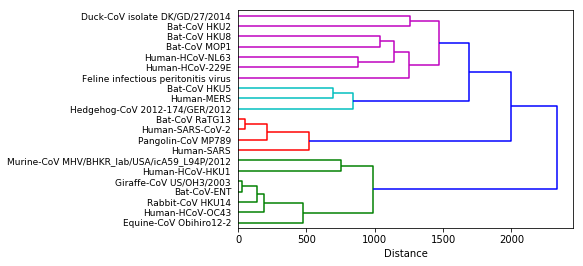

In [11]:
distance_matrix = squareform(distances)
link = linkage(distance_matrix, method = 'average')

plt.figure(figsize = )
dendrogram(link, orientation = "right", labels = list(accession_codes.keys()), leaf_font_size = 9)
plt.xlabel("Distance")
#plt.ylabel("Virus")
plt.savefig('problem2.png')
plt.show()

In [1]:
phylogeny_comments = """
Human-SARS-CoV-2 is genetically very close to Bat-Cov RaTG13 than any other human covid virus. 
Probably because of that fact, scientists are concluding that it is originated from animals.
"""

# MiniBLAST

In the previous homework, your task was to find ORF candidates, which we then ran through NCBI's BLAST to find matching sequences in other organisms. Doing so, we were able to determine whether each ORF is a gene, and if it is a gene - what that gene does. In this homework, we will implement our own simplified version of BLAST, MiniBLAST.

*Disclaimer*: Obviously, BLAST is a complicated, state-of-the-art piece of technology, and the algorithms we will use here are not used in NCBI's BLAST at all. BLAST is highly optimized and uses heuristics to obtain (very good) approximate solutions and can query thousands of sequences in a matter of seconds. Our implementation will be slightly less sophisticated and slightly slower. However, the basic functionality and end result of this implementation will be conceptually the same as that of BLAST.

## Problem 3

**TASK:**
Implement the Smith-Waterman algorithm you learned about in lectures for local sequence alignment in the `local_alignment` function in `helper_functions.py`. You can verify your implementation against provided unit tests, but note that the unit tests may not be complete, but can serve as a guide in the right direction. Your code will be run against different and complete examples for grading. **[10 points]**

Once you have implemented local sequence alignment, proceed to Problem 4.

In [84]:
from helper_functions import local_alignment

## Problem 4

In the previous homework, we found ORF candidates in the SARS-CoV-2 genome and applied some filtering to reduce the number of ORFs we have to check. We then used NCBI's BLAST to find similar sequences in other organisms, which have already been annotated. We were then able to infer whether or not our ORF candidates were genes, and if they were, what they do. We would like to go through this process again, but this time, everyone from NCBI decided to go on a yearlong cruise around the world, and their servers just happened to go down with nobody to fix them. So we are left to fend for ourselves.

We have already run our ORF finder and, having applied some clever filtering, we have managed to narrow down our search to five ORFs. We will use our MiniBLAST implementation to test each of these ORFs to known, annotated sequences from three known coronaviruses, hoping to find a good match. A good match would mean that our ORF is most likely a gene, and since we know what the gene does in the reference virus, we will assume it does the same in SARS-CoV-2.

**TASK:**
We randomly pick three viruses, Human-SARS, Bat-CoV RaTG13, and Pangolin-CoV MP789 to use as reference genomes. You are given 5 ORFs from SARS-CoV-2 that we found in the previous homework. It is your job to determine their function i.e. what gene they code for. For each ORF, calculate the local alignment to all annotated protein sequences from the three reference genomes. Score each alignment by counting the number of matching symbols in the aligned sequences e.g. A-TT and A-GG has similarity 2 (similarily to Hamming distance, but reversed).

Save your answers into the `orf_matches` variable as indicated in the cell below. Each ORF should be assigned a *closest-organism*, indicating in which reference virus the closest match was found, as well as a *homologous-gene*, indicating which gene the ORF matched to. Note any interesting observations into the `orf_comments` variable.
**[10 points]**

In [85]:
reference_genomes = [
    "Human-SARS",
    "Bat-CoV RaTG13",
    "Pangolin-CoV MP789",
]

query = "Human-SARS-CoV-2"

In [86]:
reference_proteins = {"Human-SARS": [],
                      "Bat-CoV RaTG13": [],
                      "Pangolin-CoV MP789": []
                     }

for virus in reference_genomes:
    organism_id = accession_codes[virus]
    with open('data/{}.pkl.gz'.format(organism_id), 'rb') as f:
        rec = pickle.load(f)
        
        # Finding all proteins in a base
        for r in rec.features:
            # look through the gene coding regions (CDS)
            if r.type == "CDS":
                try:   
                    name = (r.qualifiers.get("product")[0])
                    protein_seq = (r.qualifiers.get("translation")[0])
                    reference_proteins[virus].append((name, protein_seq))
                except:
                    continue

In [17]:
print(len(reference_proteins["Human-SARS"]))
print(len(reference_proteins["Bat-CoV RaTG13"]))
print(len(reference_proteins["Pangolin-CoV MP789"]))

14
10
11


First, we have to build up our reference database. To do this, look through all the coding regions (CDS) on each reference genome, extract it, and convert it to a protein sequence. Remember which gene each protein sequence belongs to, e.g. ORF1a, spike protein, ...

Here are you ORF candidates from SARS-CoV-2:

In [87]:
orf_candidates = {
    "ORF-1": (1, 11995, 13483),
    "ORF-2": (1, 26792, 27191),
    "ORF-3": (1, 23650, 25384),
    "ORF-4": (1, 9133, 13483),
    "ORF-5": (1, 25392, 26220),
}

In [88]:
# Translate the 5 orfs above to te proteins

organism_id = accession_codes[query]
proteins = []

with open('data/{}.pkl.gz'.format(organism_id), 'rb') as f:    
    rec = pickle.load(f)

# Find the orf sequence
for orf in orf_candidates:            
    strand, start, stop = orf_candidates[orf]
    sequence = rec.seq[start : stop]
    #if strand == - 1:
        #sequence = sequence.reverse_complement()
    # translate the seq into a protein and add it to proteins list
    protein = sequence.translate()
    proteins.append(str(protein))

In [89]:
def ReversedHammingDistance (s1, s2):
    """ Returns the reversed Hamming distance between strings s1 and s2. """
    distance = 0
    l = len(s1)
    for i in range(l):
        if s1[i] == s2[i]:
            distance += 1
    return distance

In [21]:
seq1 = str(proteins[0])
seq2 = str(reference_proteins["Human-SARS"][0][1])
#print(seq1)
#print(seq2)
align1, align2, score =  local_alignment(seq1, seq2, Blosum62)

In [23]:
distance = ReversedHammingDistance(align1, align2)
distance

474

In [43]:
# 5 ORFS : 3 viruses all proteins...

g = open("local_alignment_scores.txt", "w")
for ORF_nr in range(len(proteins)):
    print(ORF_nr + 1)
    g.write(" --- " + "\n")
    for key in reference_proteins:
        for j in range(len(reference_proteins[key])):
            # name
            # reference_proteins[key][j][0]
            # protein
            # reference_proteins[key][j][1]

            seq1 = proteins[ORF_nr]
            seq2 = reference_proteins[key][j][1]

            # Local alignment
            align1, align2, score =  local_alignment(seq1, seq2, Blosum62)

            # Hamming distance
            distance = ReversedHammingDistance(align1, align2)

            # Write down the viruses names and their distance
            g.write("ORF -" + str(ORF_nr + 1) + " -- : " + str(key) + " : " + str(reference_proteins[key][j][0]) + "\n")
            g.write(str(distance) + "\n") 
            g.write("\n")
            
g.close()

1
2
3
4
5


In [90]:
orf_matches = {
    "ORF-1": {
        # Both 491 matches
        "closest-organism": "Bat-CoV RaTG13, Pangolin-CoV MP789",
        "homologous-gene": "orf1ab polyprotein",
    },
    "ORF-2": {
        # Both 132 matches
        "closest-organism": "Bat-CoV RaTG13, Pangolin-CoV MP789",
        "homologous-gene": "membrane protein, membrane glycoprotein",
    },
    "ORF-3": {
        # 575 matches
        "closest-organism": "Bat-CoV RaTG13",
        "homologous-gene": "spike glycoprotein",
    },
    "ORF-4": {
        # 1440 matches
        "closest-organism": "Bat-CoV RaTG13",
        "homologous-gene": "orf1ab polyprotein",
    },
    "ORF-5": {
        # 269 matches     
        "closest-organism": "Bat-CoV RaTG13",
        "homologous-gene": "nonstructural protein NS3",
    },
}

orf_comments = """
We can again conclude that the best match with Human-SARS-CoV-2 is Bat-CoV RaTG13. 
Regarding to homologous-gene we can guess that Human-SARS-CoV-2 orfs translate to that proteins.
In those two cases where Human-SARS-CoV-2 matches the same with Bat-CoV RaTG13 and Pangolin-CoV MP789, 
the proteins are the same or similar in both cases.
So that may indicate that also Bat-CoV RaTG13 and Pangolin-CoV MP789 are close viruses. 
We can also see this in dendrogram above.
"""

In [91]:
print(491 / len(proteins[0]))
print(132 / len(proteins[1]))
print(575 / len(proteins[2]))
print(1440 / len(proteins[3]))
print(269 / len(proteins[4]))


0.9899193548387096
0.9924812030075187
0.9948096885813149
0.993103448275862
0.9746376811594203


## Problem 4b - Bonus problem

In the previous problem, we saw that we were able to find very good matches for each of our ORFs. This is because our reference genomes were very closely related to SARS-CoV-2 (refer to the phylogenetic tree from problem 2). In this exercise, we will check if we can still recover the ORF identities, the same as in Problem 4, using three less-related reference genomes: Human-MERS, Bat-CoV HKU5, and Hedgehog-CoV 2012-174/GER/2012. Report your predictions in the `orf_bonus_matches` variable. Additionally, you should report how confident you are in each prediction. Use your creativity to score your confidence in each alignment. Write your justifications and other observations to the `orf_bonus_comments` variable.
**[5 points]**

In [92]:
reference_genomes = [
    "Human-MERS",
    "Bat-CoV HKU5",
    "Hedgehog-CoV 2012-174/GER/2012",
]
query = "Human-SARS-CoV-2"

In [47]:
reference_proteins = {"Human-MERS": [],
                      "Bat-CoV HKU5": [],
                      "Hedgehog-CoV 2012-174/GER/2012": []
                     }

for virus in reference_genomes:
    organism_id = accession_codes[virus]
    with open('data/{}.pkl.gz'.format(organism_id), 'rb') as f:
        rec = pickle.load(f)
        
        # Finding all proteins in a base
        for r in rec.features:
            # look through the gene coding regions (CDS)
            if r.type == "CDS":
                try:   
                    name = (r.qualifiers.get("product")[0])
                    protein_seq = (r.qualifiers.get("translation")[0])
                    reference_proteins[virus].append((name, protein_seq))
                except:
                    continue

In [94]:
# 5 ORFS : 3 viruses all proteins...

g = open("bonus.txt", "w")
for ORF_nr in range(len(proteins)):
    print(ORF_nr + 1)
    g.write(" --- " + "\n")
    for key in reference_proteins:
        for j in range(len(reference_proteins[key])):
            # name
            # reference_proteins[key][j][0]
            # protein
            # reference_proteins[key][j][1]

            seq1 = proteins[ORF_nr]
            seq2 = reference_proteins[key][j][1]

            # Local alignment
            align1, align2, score =  local_alignment(seq1, seq2, Blosum62)

            # Hamming distance
            distance = ReversedHammingDistance(align1, align2)

            # Write down the viruses names and their distance
            g.write("ORF -" + str(ORF_nr + 1) + " -- : " + str(key) + " : " + str(reference_proteins[key][j][0]) + "\n")
            g.write("distance: " + str(distance) + "\n") 
            g.write("align len: " + str(len(align1)) + "\n")
            
            confidence1 = distance / len(align1)
            g.write("conf1: " + str(confidence1) + "\n")
         
            confidence2 = distance / len(seq1)
            g.write("conf2: " + str(confidence2) + "\n")    
            g.write("\n")
            
g.close()

1
2
3
4
5


In [96]:
orf_bonus_matches = {
    # CONFIDENCE : not confident: 1 -- 5 : completely confident
    
    "ORF-1": {
        "closest-organism": "Hedgehog-CoV 2012-174/GER/2012", 
        "homologous-gene": "ORF1ab polyprotein",
        "confidence": 3  
    },
    "ORF-2": {
        "closest-organism": "Hedgehog-CoV 2012-174/GER/2012",
        "homologous-gene": "membrane protein",
        "confidence": 3
        # I could also choose [Human-MERS : membrane protein] with the same confidence level. 
        # Confidence1 and confidence2 are equal. Also, both the same protein
    },
    "ORF-3": {
        "closest-organism": "Bat-CoV HKU5",
        "homologous-gene": "spike glycoprotein",
        "confidence": 3
        # I could also choose [Human-MERS : spike protein] with the same confidence level. 
        # Confidence1 and confidence2 are similar. Also, both similar protein.
    },
    "ORF-4": {
        "closest-organism": "Hedgehog-CoV 2012-174/GER/2012",
        "homologous-gene": "ORF1ab polyprotein",
        "confidence": 3
    },
    "ORF-5": {
        "closest-organism": "Bat-CoV HKU5",
        "homologous-gene": "ORF1ab polyprotein",
        "confidence": 2
    },
}
orf_bonus_comments = """
In this case, where we are comparing Human-SARS-CoV-2 to three less-related reference genomes, just the number of matches could lead us to wrong conclusion. 
It is better to take a look at how many percentage is the number of matches against align length. 
For example, the match score 10 from align of length 15 is better than the match score 20 from align of length 100, 
even though the score 20 is better than score 10.
So, here we choose to take a look at the number between 0 and 1 (percentage) we got from "distance / len(align)", denoted as "confidence1" in bonus.txt. 
But even with these percentage we need to be careful. The match 10 of alignment len 10 would mean percfect match but only in a local sequence and not in whole orf sequence.

What we do first is to choose the virus and a protein name only by observing "confidence1" score. Then we check if the length of alignment and orf length are close enough to 
confirm that "confidence1" is a regular score. We dont want our alignment sequence to be very small. 
So we look at percentage "confidence1", then length of alignment and also "confidence2".
In other words, we compare "confidence1" and "confidence2" score. If they are close, we can take the virus and protein as 
an apropriate answer to out problem and write them into dictionary. If not, we do the same with second best "confidence1" score.

---------------------------------------------
We determine the confidence level as:

0 - 0.19 => 1
0.2 - 0.39 => 2
0.4 - 0.59 => 3
0.6 - 0.79 => 4
0.8 - 1 => 5

---------------------------------------------

We can see that Human-SARS-CoV-2 has best (the most) matches with Hedgehog-CoV 2012-174/GER/2012 (in all cases with confidence ranked as 3), 
which we can also check on the dendrogram above.
Viruses are not as close as in the previous task, so it is quite abvious that confidence levels are not larger than the medium score (3).
Also, for Bat-CoV HKU5 and Human-MERS, the confidence percentage is lower than for Hedgehog-CoV 2012-174/GER/2012, Bat-CoV HKU5 even got 
lower confidence score (2). This is also visible on the dendogram.
"""

In [97]:
print(len(proteins[0]))
print(len(proteins[1]))
print(len(proteins[2]))
print(len(proteins[3]))
print(len(proteins[4]))


496
133
578
1450
276
